In [1]:
import math
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
from scipy.stats import gamma
from scipy.stats import lognorm
from scipy.stats import norm
from scipy.optimize import curve_fit, minimize, leastsq
import cv2

In [2]:
def get_distribution(mean, scale):
    distribution = norm.pdf(np.linspace(0, 120, 120), loc=mean, scale=scale)
    distribution = distribution / np.sum(distribution)
    return distribution

In [3]:
cases_read_path = os.getcwd()[:-5] + 'Model Dependencies/' + 'All case trends data.csv'
df = pd.read_csv(cases_read_path)
print(df)

                    Date         Public Health Unit  Cases by episode date  \
0       January 15, 2020                    Ontario                      0   
1       January 16, 2020                    Ontario                      1   
2       January 17, 2020                    Ontario                      0   
3       January 18, 2020                    Ontario                      0   
4       January 19, 2020                    Ontario                      0   
...                  ...                        ...                    ...   
37375  December 13, 2022  York Region Public Health                     89   
37376  December 14, 2022  York Region Public Health                     63   
37377  December 15, 2022  York Region Public Health                     56   
37378  December 16, 2022  York Region Public Health                     57   
37379  December 17, 2022  York Region Public Health                     39   

      7 day rolling average: Cases by episode date  \
0        

In [4]:
groups = df.groupby('Public Health Unit')
data = groups.get_group('Ontario')
print(data)

                   Date Public Health Unit  Cases by episode date  \
0      January 15, 2020            Ontario                      0   
1      January 16, 2020            Ontario                      1   
2      January 17, 2020            Ontario                      0   
3      January 18, 2020            Ontario                      0   
4      January 19, 2020            Ontario                      0   
...                 ...                ...                    ...   
1063  December 13, 2022            Ontario                    988   
1064  December 14, 2022            Ontario                    876   
1065  December 15, 2022            Ontario                    726   
1066  December 16, 2022            Ontario                    770   
1067  December 17, 2022            Ontario                    511   

     7 day rolling average: Cases by episode date  Cases rate by episode date  \
0                                               -                         0.0   
1        

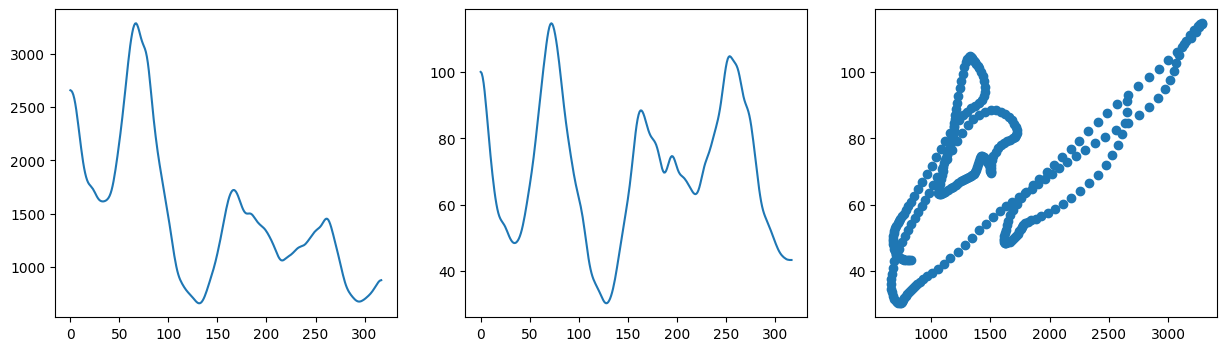

In [5]:
raw_cases = data['Cases by reported date'].to_numpy().astype(float)[750:]
raw_hospitalized = data['Hospitalizations'].to_numpy().astype(float)[750:]
cases = cv2.GaussianBlur(raw_cases.reshape(raw_cases.shape[0], 1), (25, 25), 0)
hospitalizations =cv2.GaussianBlur(raw_hospitalized.reshape(raw_hospitalized.shape[0], 1), (25, 25), 0)

# fitted_hospitalization =
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(cases)
plt.subplot(1, 3, 2)
plt.plot(hospitalizations)
# plt.plot(raw_cases)
plt.subplot(1, 3, 3)
a = 5
plt.scatter(cases[:-a], hospitalizations[a:])
plt.show()

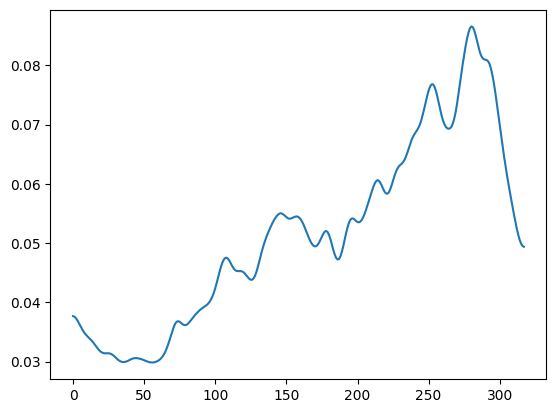

In [6]:
rate = (hospitalizations / cases).flatten()
plt.plot(rate)
plt.show()

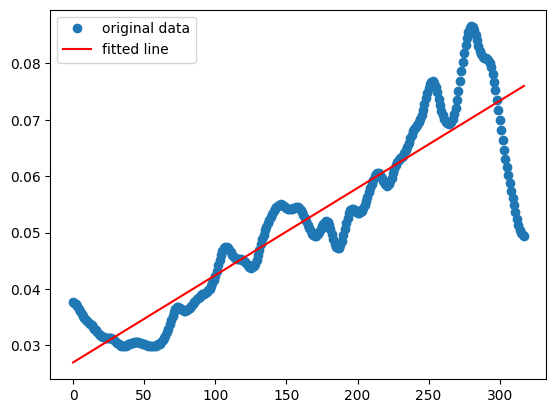

In [7]:
import scipy

res = scipy.stats.linregress(x=np.linspace(0, rate.shape[0]-1, rate.shape[0]), y=rate)
plt.plot(rate, 'o', label='original data')
plt.plot(res.intercept + res.slope*np.linspace(0, rate.shape[0]-1, rate.shape[0]), 'r', label='fitted line')
slope_bias = res.slope
intercept_bias = res.intercept
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import r2_score

def ssd(A,B):
    dif = A.ravel() - B.ravel()
    sdd =  np.dot( dif, dif )
    mse = np.mean((np.square(A - B)))
    rsquare = 1 - r2_score(A, B)
    return rsquare

In [9]:
def fit_case(x, a, b):
    rslt = np.zeros(shape=x.shape)
    for y in x:
        y = int(y)
        dist = (get_distribution(a, b))[:y]
        dist = dist[::-1]

        if y > len(dist):
            data = cases[y - len(dist):y].flatten()
        else:
            data = cases[:y].flatten()

        rate = y * slope_bias + intercept_bias

        rslt[y - 10] = np.sum(np.multiply(data, dist)) * rate
    return rslt

In [10]:
def fit_minimize(d):
    a = d[0]
    b = d[1]
    x = np.linspace(0, hospitalizations.shape[0] - 1, hospitalizations.shape[0] )
    rslt = np.zeros(shape=x.shape)
    for y in x:
        y = int(y)
        dist = (get_distribution(a, b))[:y]
        dist = dist[::-1]

        if y > len(dist):
            data = cases[y - len(dist):y].flatten()
        else:
            data = cases[:y].flatten()
        rate = y * slope_bias + intercept_bias

        rslt[y - 10] = np.sum(np.multiply(data, dist)) * rate
    return ssd(rslt[5:-5], hospitalizations[5:-5])

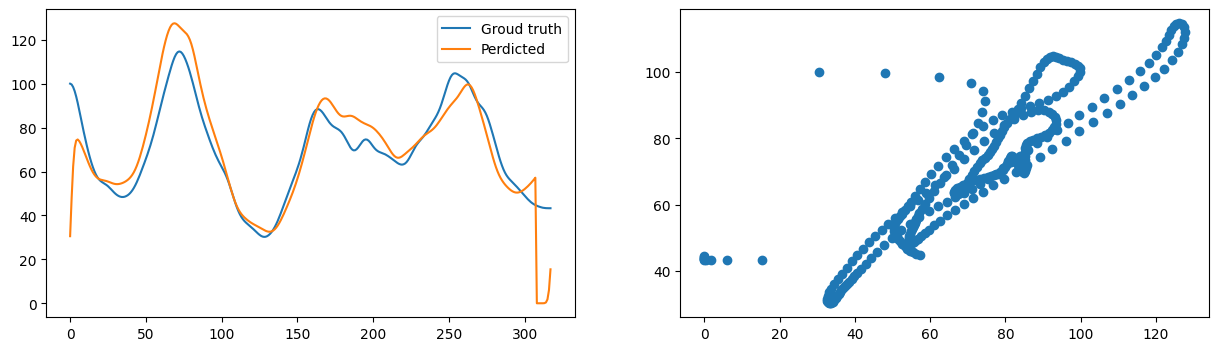

0.1681201321398833


In [11]:
xdata = np.linspace(0, hospitalizations.flatten().shape[0] - 1, hospitalizations.flatten().shape[0]).astype(int)
ydata = hospitalizations.flatten()
a = 10
b = 1.762761705083795
test = fit_case(xdata, a, b)
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(ydata, label='Groud truth')
plt.plot(test, label='Perdicted')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(test, ydata)
plt.show()
print(fit_minimize([9, b]))

In [12]:
clip = 10
xdata = np.linspace(0, hospitalizations.flatten().shape[0] - 1, hospitalizations.flatten().shape[0]).astype(int)[clip:]
ydata = hospitalizations.flatten()[clip:]
x0 = np.asarray((10, 1))
res = scipy.optimize.minimize(fit_minimize, x0=x0, method='SLSQP')

10.0
1.0
0.16476138068807633
mean =  10.0
scale =  1.0


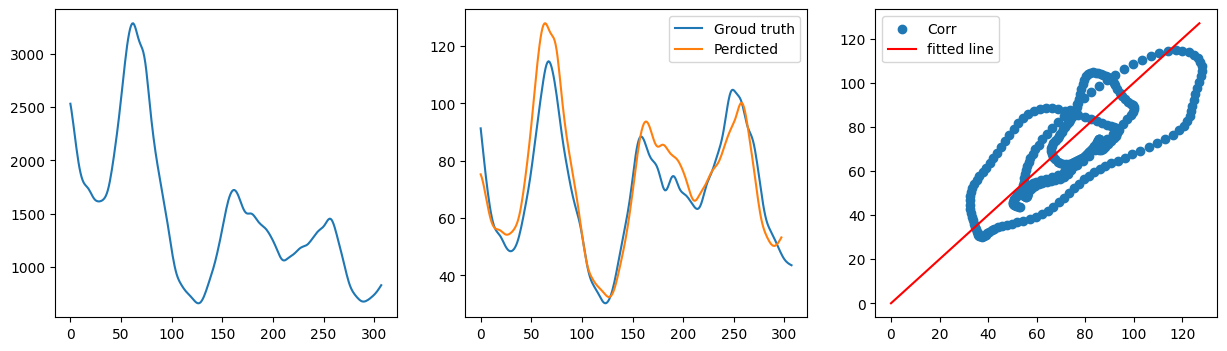

In [13]:
print(res.x[0])
print(res.x[1])
clip = 5
# perdicted = fit_case(xdata, res.x[0], res.x[1])
perdicted = fit_case(xdata, res.x[0], res.x[1])
print(fit_minimize(res.x))
print('mean = ', res.x[0])
print('scale = ', res.x[1])
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(cases[clip:-clip])
plt.subplot(1, 3, 2)
plt.plot(hospitalizations[clip:-clip], label='Groud truth')
plt.plot(perdicted[clip:-clip], label='Perdicted')
plt.legend()
plt.subplot(1, 3, 3)
plt.scatter(perdicted[clip:-clip], ydata[clip:-clip], label='Corr')
res_line = scipy.stats.linregress(x=perdicted[clip:-clip], y=ydata[clip:-clip])
plt.plot(1*np.linspace(0, np.max(perdicted[clip:-clip]).astype(int), np.max(perdicted[clip:-clip]).astype(int) + 1), 'r', label='fitted line')
plt.legend()
plt.show()

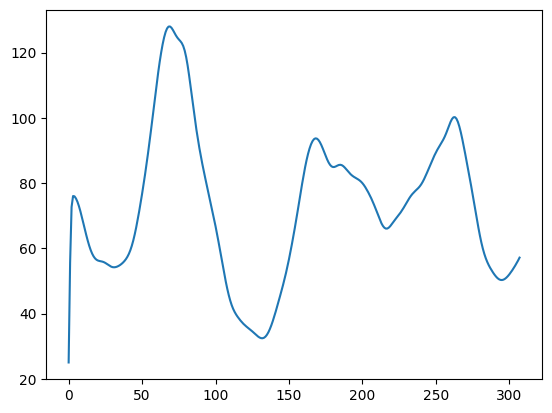

In [14]:
rslt = fit_case(xdata, res.x[0], res.x[1])
plt.plot(rslt)
plt.show()